# Performing geospatial queries in RethinkDB

RethinkDB supports a number of [geospatial features](http://rethinkdb.com/docs/geo-support/javascript/) that you can use to build location-aware applications. The database's geographical types include points, lines, and polygons. Geospatial queries makes it easy to compute the distance between points, detect intersecting regions, and more.

## Fetch and process the earthquake data

The USGS publishes a [global feed](http://rethinkdb.com/blog/earthquake-geojson/) that includes data about every earthquake detected over the past 30 days. The feed is updated with the latest earthquakes every 15 minutes. Use the `r.http` command to fetch the data:

In [1]:
%r r.http("http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_month.geojson")["features"][0:3]

[
    {
        "geometry": {
            "type": "Point", 
            "coordinates": [
                -27.031, 
                -55.3659, 
                30.74
            ]
        }, 
        "type": "Feature", 
        "id": "us20002wlt", 
        "properties": {
            "rms": 1.14, 
            "code": "20002wlt", 
            "cdi": 1, 
            "sources": ",us,", 
            "nst": null, 
            "tz": -120, 
            "title": "M 5.0 - 148km N of Visokoi Island, South Georgia and the South Sandwich Islands", 
            "magType": "mb", 
            "detail": "http://earthquake.usgs.gov/earthquakes/feed/v1.0/detail/us20002wlt.geojson", 
            "sig": 385, 
            "net": "us", 
            "type": "earthquake", 
            "status": "reviewed", 
            "updated": 1436544969012, 
            "felt": 0, 
            "gap": 112, 
            "dmin": 5.574, 
            "mag": 5, 
            "alert": null, 
            "types": ",cap,dyfi,geoserve

The feed includes an array of geographical points that represent earthquake epicenters. Each point comes with additional metadata, such as the magnitude and time of the associated seismic event. Before we proceed, create a table to store the earthquake data:

In [4]:
%r r.db("test").table_create("quake")

{
    "tables_created": 1, 
    "config_changes": [
        {
            "old_val": null, 
            "new_val": {
                "primary_key": "id", 
                "durability": "hard", 
                "db": "test", 
                "shards": [
                    {
                        "primary_replica": "c77cc04d96c0_6gt", 
                        "replicas": [
                            "c77cc04d96c0_6gt"
                        ]
                    }
                ], 
                "write_acks": "majority", 
                "id": "3f6a155f-74a6-45a6-be4b-72bdce827d00", 
                "name": "quake"
            }
        }
    ]
}



The next step is transforming the data and inserting it into a table. Using the `merge` command, you can iterate over earthquake records from the USGS feed and replace the value of the `geometry` property with an actual point object. The output of the merge command can be passed directly to the `insert` command on the table where you want to store the data:

In [13]:
%r r.table("quake").insert( \
    r.http("earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_month.geojson")["features"] \
     .merge({ \
        "time": r.epoch_time(r.row["properties"]["time"] / 1000), \
        "geometry": r.point( \
            r.row["geometry"]["coordinates"][0], \
            r.row["geometry"]["coordinates"][1])}))


{
    "skipped": 0, 
    "deleted": 0, 
    "unchanged": 0, 
    "errors": 0, 
    "replaced": 0, 
    "inserted": 1181
}



The `r.point` command takes longitude as the first parameter and latitude as the second parameter, just like GeoJSON coordinate arrays. In the example above, the `r.point` command is passed the coordinate values from the earthquake object’s geometry property.

## Perform geospatial queries

The next step is to create an index on the geometry property. Use the `index_create` command with the geo option to create an index that supports geospatial queries:

In [15]:
%r r.table("quake").index_create("geometry", geo=True)

{
    "created": 1
}



Now that there is an index, try querying the data. For the first query, try counting all of the earthquakes that took place within 200 miles of Tokyo:

In [16]:
%r r.table('quake').get_intersecting( \
    r.circle([139.69, 35.68], 200, unit="mi"), index="geometry").count()

6



In the example above, the `get_intersecting` command will find all of the records in the quakes table that have a geographic object stored in the geometry property that intersects with the specified circle. The `r.circle` command creates a polygon that approximates a circle with the desired radius and center point. The `unit` option tells the `r.circle` command to use a particular unit of measurement (miles, in this case) to compute the radius. The coordinates used in the above example correspond with the latitude and longitude of Tokyo.

## Plotting earthquake data

Now that you know how to perform geospatial queries, let's use `matplotlib` to render some graphs and maps. Expanding on the example above, let's plot all of the earthquakes near Tokyo:

In [17]:
%matplotlib inline

In [77]:
import os, mplleaflet
from matplotlib import pyplot
import rethinkdb as r

dbhost = os.environ.get("RETHINKDB_PORT_28015_TCP_ADDR", "localhost")
dbport = os.environ.get("RETHINKDB_PORT_28015_TCP_PORT", 28015)

conn = r.connect(host=dbhost, port=dbport)

near_tokyo = list(r.table("quake").get_intersecting(
  r.circle([139.69, 35.68], 200, unit="mi"), index="geometry")["geometry"] \
  .map(r.row.to_geojson()["coordinates"]).run(conn))

conn.close()

print near_tokyo

pyplot.plot([p[0] for p in near_tokyo], [p[1] for p in near_tokyo], 'rs')
mplleaflet.display()

[[140.0649, 36.21], [139.1552, 33.2428], [141.5866, 37.5366], [137.3947, 34.4406], [141.0457, 35.6923], [142.3242, 36.6824], [137.8565, 34.7673], [140.8211, 35.6806], [142.0924, 36.2156], [142.2326, 36.7263], [141.931, 35.5949], [141.1149, 33.3777]]


And finally, let's generate a bar graph that shows the number of earthquakes per day for the past month:

[[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], [12, 12, 13, 13, 15, 15, 16, 17, 16, 16, 13, 9, 9, 10, 10, 10, 8, 15, 10, 8, 8, 9, 15, 10, 16, 5, 6, 13]]


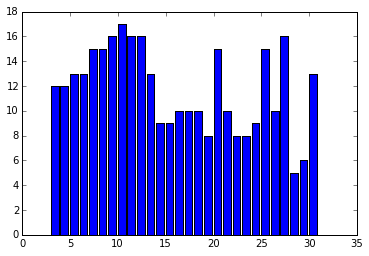

In [75]:
import os
from matplotlib import pyplot
import rethinkdb as r

dbhost = os.environ.get("RETHINKDB_PORT_28015_TCP_ADDR", "localhost")
dbport = os.environ.get("RETHINKDB_PORT_28015_TCP_PORT", 28015)

conn = r.connect(host=dbhost, port=dbport)

quakes = r.table("quake") \
    .merge({"date": r.epoch_time(r.row["properties"]["time"] / 1000).date()}) \
    .filter(r.row["date"].month() == r.now().month() - 1) \
    .group(r.row["date"].day()).count() \
    .ungroup().order_by(r.row["group"]) \
    .do([r.row["group"], r.row["reduction"]]).run(conn)
    
print quakes

conn.close()

pyplot.bar(quakes[0], quakes[1])
pyplot.show()

To learn more about using geospatial queries in RethinkDB, check out the [documentation](http://rethinkdb.com/docs/geo-support/javascript/).